In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from deepface import DeepFace
import pandas as pd
import os
from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings('ignore')

2024-04-24 10:01:12.974495: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-04-24 10:01:12.974529: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Load metadata from the VGG-Face Dataset

In [4]:
meta_df = pd.read_csv('data/VGG-Face2/meta/identity_meta.csv', on_bad_lines='skip')

In [6]:
meta_df

,Class_ID,Name,Sample_Num,Flag,Gender
0,n000001,"""14th_Dalai_Lama""",424,0,m
1,n000002,"""A_Fine_Frenzy""",315,1,f
2,n000003,"""A._A._Gill""",205,1,m
3,n000004,"""A._J._Buckley""",387,1,m
4,n000005,"""A._J._Pierzynski""",229,1,m
...,...,...,...,...,...
9111,n009287,"""Ni_Ping""",226,0,f
9112,n009288,"""Song_Dandan""",252,0,f
9113,n009289,"""Pan_Hong""",236,0,f
9114,n009291,"""Stephen_Chow""",200,0,m


## Find 100 individuals of every ethnicity

In [56]:
counts = {'indian m': 0, 'indian f': 0, 'black m': 0, 'black f': 0, 'white m': 0, 'white f': 0, 'middle eastern m': 0, 'middle eastern f': 0, 'latino hispanic m': 0, 'latino hispanic f': 0, 'asian f': 0, 'asian m': 0}
ids = {group: [] for group in counts.keys()}

In [61]:
data_dir = 'data/train'

In [64]:
for class_id in tqdm(meta_df['Class_ID'].values):
    try:
        fname = os.listdir(os.path.join(data_dir, class_id))[0]
        objs = DeepFace.analyze(img_path = os.path.join(data_dir, class_id, fname), actions = ['age', 'race', 'emotion'], silent=True)[0]
        group = objs['dominant_race'] + meta_df.loc[meta_df['Class_ID'] == class_id,  ' Gender'].values[0]

        if counts[group] >= 50: continue

        counts[group] += 1
        ids[group].append(class_id)
    except Exception as e:
        pass
    if all([v >= 50 for v in counts.values()]): break

  0%|          | 0/9116 [00:00<?, ?it/s]

## Save so we dont have to rerun

In [11]:
import pickle
SAVE = False
if SAVE:
    with open('pkls/counts.pkl', 'wb') as fh:
        pickle.dump(counts, fh)
    with open('pkls/ids.pkl', 'wb') as fh:
        pickle.dump(ids, fh)
else:
    with open('pkls/counts.pkl', 'rb') as fh:
        counts = pickle.load(fh)
    with open('pkls/ids.pkl', 'rb') as fh:
        ids = pickle.load(fh)

## Copy all the curated images into our list

In [76]:
import shutil
from random import sample
# Make all the directories
for group, l in tqdm(ids.items()):
    for class_id in l:
        if not os.path.exists(os.path.join('./data/curated/', class_id)):
            os.mkdir(os.path.join('./data/curated/', class_id))

# Copy in 3 random images from each class in to the folder 
for group, l in tqdm(ids.items()):
    for class_id in l:
        # Get original images
        test = False
        if os.path.exists(os.path.join(data_dir, class_id)):
            fnames = os.listdir(os.path.join(data_dir, class_id))
        else:
            test = True
            fnames = os.listdir(os.path.join('data/test', class_id))
        for fname in sample(fnames, 3):
            if not test:
                og_image = os.path.join(data_dir, class_id, fname)
            else:
                og_image = os.path.join('data/test', class_id, fname)
            new_image = os.path.join('./data/curated', class_id, fname)
            shutil.copyfile(og_image, new_image)

    

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

## Run fawkes on all the images (shell not here)
Run the following bash
`ls data/curated/ | while read file; do ./protection -d "data/curated/$file"; done`

This can take quite a while (60 seconds per image). You can check progress with `find . -type f | awk -F'.' '!/^.$/ && NF>1 {print $NF}' | sort | uniq -c | sort -nr`

## Run the  on pairs of images and their fawkes counter parts
For each individual, we will randomly sample one of their images. We will then run the `DeepFace` verification function against all the other non-cloaked images. We will then run the verification against all of the cloaked versions. We will then take the difference between the confidence of the non cloaked and the cloaked versions of the images. This will be the score for that individual. We can then look at how the score very for each group.

In [41]:
from random import sample
d = 'data/curated'

scores = {}
for group, l in ids.items():
    for class_id in l:
        scores[class_id] = {'cloaked':[], 'non_cloaked': [], 'diffs': []}

# Remove the .jpg and add the _low_cloaked.png
cloaked_fname = lambda fname_: fname_[:-4] + '_low_cloaked.png'

need_to_run = []
for class_id in tqdm(os.listdir(d)):
    if class_id == 'protection' or class_id == 'run.sh': continue
    try:
        fnames = os.listdir(os.path.join(d, class_id))

        if not len(list(filter(lambda fname_: fname_.endswith('.png'), fnames))) > 0:
            need_to_run.append(class_id)
            continue

        non_cloaked = list(filter(lambda fname_: fname_.endswith(".jpg"), fnames))
        base = sample(non_cloaked, 1)[0]
        base_fname = os.path.join(d, class_id, base)
        non_cloaked_ = list(filter(lambda fname_: fname_ != base, non_cloaked))    
        for nc in non_cloaked_:
            c = cloaked_fname(nc)    
            res_nc = DeepFace.verify(img1_path = base_fname, img2_path = os.path.join(d, class_id, nc), enforce_detection=False)['distance']
            res_c = DeepFace.verify(img1_path = base_fname, img2_path = os.path.join(d, class_id, c), enforce_detection=False)['distance']
    
            scores[class_id]['cloaked'].append(res_c)
            scores[class_id]['non_cloaked'].append(res_nc)
            scores[class_id]['diffs'].append(res_nc - res_c)
    except Exception as e:
        print(e)

  0%|          | 0/528 [00:00<?, ?it/s]

In [53]:
import pickle
SAVE = True
if SAVE:
    with open('pkls/scores.pkl', 'wb') as fh:
        pickle.dump(scores, fh)
else:
    with open('pkls/scores.pkl', 'rb') as fh:
        scores = pickle.load(fh)
        

## Generate scores by group

In [50]:
import numpy as np
def calculate_stats(scores, class_ids):
    results = {}
    for group, ids in class_ids.items():
        all_diffs = []
        for class_id in ids:
            if class_id in scores:
                all_diffs.extend(scores[class_id]['diffs'])
        if all_diffs:
            mean_diff = np.mean(all_diffs)
            std_diff = np.std(all_diffs)
            results[group] = {'mean': mean_diff, 'std_deviation': std_diff}
        else:
            results[group] = {'mean': None, 'std_deviation': None}
    return results

stats = calculate_stats(scores, ids)

## Visualise the outputs

In [54]:
import matplotlib.pyplot as plt

In [60]:
import seaborn as sns

{}

In [81]:
groups = {}

for k, v in stats.items():
    split = k.rsplit(" ")
    gender = split[-1]
    group = " ".join(split[:-1])

    if group not in groups:
        groups[group] = {'m': 0, 'f': 0, 't': 0}

    groups[group][gender] += v['mean']
    groups[group]['t'] += v['mean']
for group in groups:
    groups[group]['t'] = groups[group]['t'] / 2 
    for k, v in groups[group].items():
        groups[group][k] = v * -1

In [82]:
total = 0
for group in groups:
    for k, v in groups[group].items():
        total += v
        
for group in groups:
    groups[group]['t'] = groups[group]['t'] / 2 
    for k, v in groups[group].items():
        groups[group][k] = v / total
    

In [83]:
groups

{'indian': {'m': 0.05221431561724165,
  'f': 0.08206152707404497,
  't': 0.033568960672821654},
 'black': {'m': 0.034345071001028,
  'f': 0.031219419123158745,
  't': 0.016391122531046687},
 'white': {'m': 0.05063432172213314,
  'f': 0.10730154298791161,
  't': 0.03948396617751119},
 'middle eastern': {'m': 0.08237083396677969,
  'f': 0.0600749196563451,
  't': 0.035611438405781196},
 'latino hispanic': {'m': 0.021852076686803664,
  'f': 0.06401152939843262,
  't': 0.02146590152130907},
 'asian': {'m': 0.01685326723244998,
  'f': 0.06372784220033757,
  't': 0.02014527735819689}}

In [85]:
df = pd.DataFrame(groups)

In [89]:
df.index = ['male', 'female', 'all']

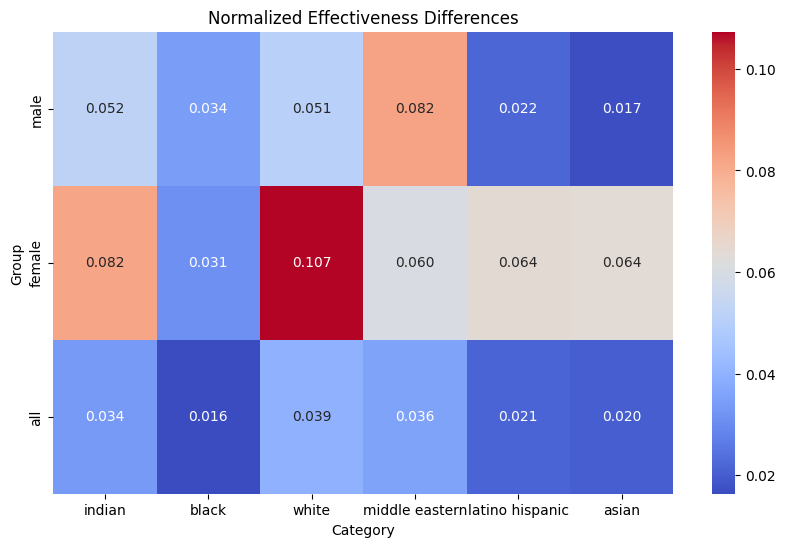

In [93]:
# Plotting with Seaborn
plt.figure(figsize=(10, 6))  # Optional: Adjust figure size
ax = sns.heatmap(df, annot=True, cmap='coolwarm', fmt=".3f")
ax.set_title('Normalized Effectiveness Differences')
ax.set_xlabel('Category')
ax.set_ylabel('Group')
plt.savefig('./norm_differences.jpg')
plt.show()

<Figure size 640x480 with 0 Axes>